In [1]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm 
import numpy as np
from skimage.transform import resize
from numpy.fft import fftn, fftshift

import matplotlib.pyplot as plt
import matplotlib

import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
torch.__version__

'1.6.0'

In [3]:
#!wget -L https://github.com/mcherukara/PtychoNN/blob/master/data/20191008_39_amp_pha_10nm_full.npy?raw=true 
#!wget -L https://github.com/mcherukara/PtychoNN/blob/master/data/20191008_39_diff.npz?raw=true


In [4]:
plt.style.use('seaborn-white')
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20
plt.viridis()

<Figure size 432x288 with 0 Axes>

In [5]:
def plot3(data,titles):
    if(len(titles)<3):
        titles=["Plot1", "Plot2", "Plot3"]
    fig,ax = plt.subplots(1,3, figsize=(20,12))
    im=ax[0].imshow(data[0])
    ax[0].set_title(titles[0])
    ax[0].axis('off')
    plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)
    im=ax[1].imshow(data[1])
    ax[1].set_title(titles[1])
    ax[1].axis('off')
    plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
    im=ax[2].imshow(data[2])
    ax[2].set_title(titles[2])
    ax[2].axis('off')
    plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)

In [6]:
EPS32 = (1.0 + np.finfo(np.float32).eps)
def histogram2d_engine(raw, npt, 
                       radial_range=None,
                       azimuth_range=None
                       ):
    """Implementation of 2D rebinning engine using pure numpy histograms
    
    :param npt: number of points to integrate over in (azimuthal, radial) dimension
    :param raw: 2D array with the raw signal
    """
    
    shape = raw.shape
    y = np.linspace(-shape[0] / 2, shape[0] / 2, shape[0])
    x = np.linspace(-shape[1] / 2, shape[1] / 2, shape[1])
    yy, xx = np.meshgrid(y, x, indexing='ij')
    
    radial = (yy**2 + xx**2)**0.5
    azimuth = np.arctan2(yy, xx)
    
    raw = np.ascontiguousarray(raw.ravel())
    radial = radial.ravel()
    azimuth = azimuth.ravel()
    
    if radial_range is None:
        radial_range = (radial.min(), radial.max() * EPS32)
    if azimuth_range is None:
        azimuth_range = (azimuth.min(), azimuth.max() * EPS32)
    
    histo_count, position_azim, position_rad = np.histogram2d(azimuth, radial, npt, weights=raw, range=[azimuth_range, radial_range])

    bins_azim = (position_azim[1:] + position_azim[:-1]) / 2.0
    bins_rad = (position_rad[1:] + position_rad[:-1]) / 2.0
    return histo_count, bins_azim, bins_rad

In [7]:
torch.cuda.device_count()

2

In [8]:
EPOCHS = 20
NGPUS = torch.cuda.device_count()
BATCH_SIZE = NGPUS * 64
LR = 1e-3 
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

GPUs: 2 Batch size: 128 Learning rate: 0.001


In [9]:
H,W = 64,64
NLINES = 100 #How many lines of data to use for training?
NLTEST = 60 #How many lines for the test set?

N_VALID = 805 #How much to reserve for validation

**Note that the "path" can be different for different directory structures. For example, the original code in train.ipynb contains a different path.**  

In [10]:
path = os.getcwd()

MODEL_SAVE_PATH = path +'/trained_model/'
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)

In [11]:
real_space = np.load('../data/20191008_39_amp_pha_10nm_full.npy')#np.load(path+'/../data/20191008_39_amp_pha_10nm_full.npy')

In [12]:
amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

In [13]:
try:
    
    data_diffr_red = np.load('../data/20191008_39_diff_azimuth.npz')['arr_0']
except:
    data_diffr = np.load('../data/20191008_39_diff.npz')['arr_0']#np.load(path+'/../data/20191008_39_diff.npz')['arr_0']

    print(data_diffr.shape)
    #plt.matshow(np.log10(data_diffr[0,0]))

    data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), dtype=float)
    for i in tqdm(range(data_diffr.shape[0])):
        for j in range(data_diffr.shape[1]):
            histo_count_2d, bins_azim, bins_rad = histogram2d_engine(data_diffr[i,j]**2, (64, 94))
            data_diffr_red[i,j] = histo_count_2d[:,:64]#resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
            #data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3, 0, data_diffr_red[i,j])
    np.savez_compressed('../data/20191008_39_diff_azimuth.npz', data_diffr_red)

In [17]:
#data_diffr_red = np.log(data_diffr_red + 1)
data_diffr_red = np.fft.fftshift(data_diffr_red**0.5, axes=(-1,-2))

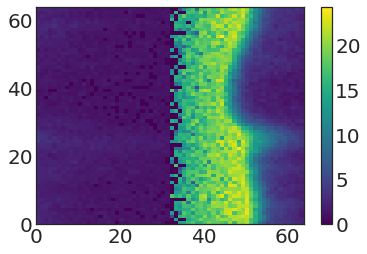

In [18]:
plt.pcolormesh(data_diffr_red[0,0])
plt.colorbar()
plt.show()

In [19]:
tst_strt = amp.shape[0]-NLTEST #Where to index from
print(tst_strt)

X_train = data_diffr_red[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_train = amp[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_train = ph[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

101
(16100, 1, 64, 64) (3600, 1, 64, 64)


In [20]:
#Training data
X_train_tensor = torch.Tensor(X_train) 
Y_I_train_tensor = torch.Tensor(Y_I_train) 
Y_phi_train_tensor = torch.Tensor(Y_phi_train)

#Test data
X_test_tensor = torch.Tensor(X_test) 
Y_I_test_tensor = torch.Tensor(Y_I_test) 
Y_phi_test_tensor = torch.Tensor(Y_phi_test)

print(Y_phi_train.max(), Y_phi_train.min())

print(X_train_tensor.shape, Y_I_train_tensor.shape, Y_phi_train_tensor.shape)

train_data = TensorDataset(X_train_tensor,Y_I_train_tensor,Y_phi_train_tensor)
test_data = TensorDataset(X_test_tensor)

3.1268637 -1.564053
torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64])


In [21]:
N_TRAIN = X_train_tensor.shape[0]
train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-N_VALID,N_VALID])
print(len(train_data2),len(valid_data),len(test_data))

15295 805 3600


In [22]:
#download and load training data
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [23]:
nconv = 32


class recon_model(nn.Module):

    def __init__(self):
        super(recon_model, self).__init__()


        self.encoder = nn.Sequential( # Appears sequential has similar functionality as TF avoiding need for separate model definition and activ
          nn.Conv2d(in_channels=1, out_channels=nconv, kernel_size=3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv, nconv, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.MaxPool2d((2,2)),

          nn.Conv2d(nconv, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),          
          nn.ReLU(),
          nn.MaxPool2d((2,2)),

          nn.Conv2d(nconv*2, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),          
          nn.ReLU(),
          nn.MaxPool2d((2,2)),
          )

        self.decoder1 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),
            
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)),
          nn.Sigmoid() #Amplitude model
          )

        self.decoder2 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),
            
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)),
          nn.Tanh() #Phase model
          )
    
    def forward(self,x):
        with torch.cuda.amp.autocast():
            x1 = self.encoder(x)
            amp = self.decoder1(x1)
            ph = self.decoder2(x1)

            #Restore -pi to pi range
            ph = ph*np.pi #Using tanh activation (-1 to 1) for phase so multiply by pi

        return amp,ph

In [24]:
model = recon_model()
for ft_images,amps,phs in trainloader:
    print("batch size:", ft_images.shape)
    amp_train, ph_train = model(ft_images)
    print(amp_train.shape, ph_train.shape)
    print(amp_train.dtype, ph_train.dtype)
    break

batch size: torch.Size([128, 1, 64, 64])


/home/skandel/miniconda3/envs/tf2/lib/python3.8/site-packages/torch/nn/functional.py:3118: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


torch.Size([128, 1, 64, 64]) torch.Size([128, 1, 64, 64])
torch.float32 torch.float32


In [25]:
summary(model,(1,H,W),device="cpu")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model) #Default all devices

model = model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 8, 8]           --
|    └─Conv2d: 2-1                       [-1, 32, 64, 64]          320
|    └─ReLU: 2-2                         [-1, 32, 64, 64]          --
|    └─Conv2d: 2-3                       [-1, 32, 64, 64]          9,248
|    └─ReLU: 2-4                         [-1, 32, 64, 64]          --
|    └─MaxPool2d: 2-5                    [-1, 32, 32, 32]          --
|    └─Conv2d: 2-6                       [-1, 64, 32, 32]          18,496
|    └─ReLU: 2-7                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-8                       [-1, 64, 32, 32]          36,928
|    └─ReLU: 2-9                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-10                   [-1, 64, 16, 16]          --
|    └─Conv2d: 2-11                      [-1, 128, 16, 16]         73,856
|    └─ReLU: 2-12                        [-1, 128, 16, 16]         --

In [26]:
#Optimizer details
iterations_per_epoch = np.floor((N_TRAIN-N_VALID)/BATCH_SIZE)+1 #Final batch will be less than batch size
step_size = 6*iterations_per_epoch #Paper recommends 2-10 number of iterations, step_size is half cycle
print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))

criterion = nn.L1Loss()#
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR / 10, max_lr=LR, step_size_up=step_size,
                                              cycle_momentum=False, mode='triangular2')
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, min_lr=LR / 10)

LR step size is: 720.0 which is every 6 epochs


In [27]:
#Function to update saved model if validation loss is minimum
def update_saved_model(model, path):
    if not os.path.isdir(path):
        os.mkdir(path)
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))
    if (NGPUS>1):    
        torch.save(model.module.state_dict(),path+'best_model.pth') #Have to save the underlying model else will always need 4 GPUs
    else:
        torch.save(model,path+'best_model.pth')

**For the "mixed precision" part we just modify the original code slightly to include the 'scaler' in the following code blocks**

In [28]:
scaler = torch.cuda.amp.GradScaler()

In [29]:
def train(trainloader,metrics):
    tot_loss = 0.0
    loss_amp = 0.0
    loss_ph = 0.0
    
    for i, (ft_images,amps,phs) in tqdm(enumerate(trainloader)):
        ft_images = ft_images.to(device) #Move everything to device
        amps = amps.to(device)
        phs = phs.to(device)

        pred_amps, pred_phs = model(ft_images) #Forward pass

        #Compute losses
        loss_a = criterion(pred_amps,amps) #Monitor amplitude loss
        loss_p = criterion(pred_phs,phs) #Monitor phase loss but only within support (which may not be same as true amp)
        loss = loss_a + loss_p #Use equiweighted amps and phase
        
       
        #print(loss)
        #Zero current grads and do backprop
        optimizer.zero_grad() 
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        #optimizer.step()

        tot_loss += loss.detach().item()
        loss_amp += loss_a.detach().item()
        loss_ph += loss_p.detach().item()
        
        

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        scaler.update()
        #print(loss)
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    
    metrics['losses'].append([tot_loss/i,loss_amp/i,loss_ph/i]) 
    

def validate(validloader,metrics):
    tot_val_loss = 0.0
    val_loss_amp = 0.0
    val_loss_ph = 0.0
    for j, (ft_images,amps,phs) in enumerate(validloader):
        ft_images = ft_images.to(device)
        amps = amps.to(device)
        phs = phs.to(device)
        pred_amps, pred_phs = model(ft_images) #Forward pass
    
    
        val_loss_a = criterion(pred_amps,amps) 
        val_loss_p = criterion(pred_phs,phs)
        val_loss = val_loss_a + val_loss_p
           
        tot_val_loss += val_loss.detach().item()
        val_loss_amp += val_loss_a.detach().item()
        val_loss_ph += val_loss_p.detach().item()  
    metrics['val_losses'].append([tot_val_loss/j,val_loss_amp/j,val_loss_ph/j])
  
  #Update saved model if val loss is lower
    if(tot_val_loss/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],tot_val_loss/j))
        metrics['best_val_loss'] = tot_val_loss/j
        update_saved_model(model, MODEL_SAVE_PATH)

In [30]:
metrics = {'losses':[],'val_losses':[], 'lrs':[], 'best_val_loss' : np.inf}

In [31]:

#train(trainloader,metrics)

for epoch in range (200):#EPOCHS):

  
  #Set model to train mode
  model.train() 
    
  #Training loop
  train(trainloader,metrics)

    
  #Switch model to eval mode
  model.eval()
    
  #Validation loop
  validate(validloader,metrics)
  
  print('Epoch: %d | FT  | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))
  print('Epoch: %d | Amp | Train Loss: %.4f | Val Loss: %.4f' %(epoch, metrics['losses'][-1][1], metrics['val_losses'][-1][1]))
  print('Epoch: %d | Ph  | Train Loss: %.3f | Val Loss: %.3f' %(epoch, metrics['losses'][-1][2], metrics['val_losses'][-1][2]))
  print('Epoch: %d | Ending LR: %.6f ' %(epoch, metrics['lrs'][-1][0]))

120it [00:18,  6.47it/s]


Saving improved model after Val Loss improved from inf to 0.87570
Epoch: 0 | FT  | Train Loss: 0.86269 | Val Loss: 0.87570
Epoch: 0 | Amp | Train Loss: 0.1361 | Val Loss: 0.0936
Epoch: 0 | Ph  | Train Loss: 0.727 | Val Loss: 0.782
Epoch: 0 | Ending LR: 0.000250 


120it [00:17,  6.93it/s]


Saving improved model after Val Loss improved from 0.87570 to 0.79543
Epoch: 1 | FT  | Train Loss: 0.70996 | Val Loss: 0.79543
Epoch: 1 | Amp | Train Loss: 0.0300 | Val Loss: 0.0157
Epoch: 1 | Ph  | Train Loss: 0.680 | Val Loss: 0.780
Epoch: 1 | Ending LR: 0.000400 


120it [00:17,  6.86it/s]


Saving improved model after Val Loss improved from 0.79543 to 0.79162
Epoch: 2 | FT  | Train Loss: 0.69567 | Val Loss: 0.79162
Epoch: 2 | Amp | Train Loss: 0.0184 | Val Loss: 0.0127
Epoch: 2 | Ph  | Train Loss: 0.677 | Val Loss: 0.779
Epoch: 2 | Ending LR: 0.000550 


120it [00:17,  6.85it/s]


Epoch: 3 | FT  | Train Loss: 0.68481 | Val Loss: 0.79524
Epoch: 3 | Amp | Train Loss: 0.0118 | Val Loss: 0.0196
Epoch: 3 | Ph  | Train Loss: 0.673 | Val Loss: 0.776
Epoch: 3 | Ending LR: 0.000700 


120it [00:17,  6.86it/s]


Saving improved model after Val Loss improved from 0.79162 to 0.79052
Epoch: 4 | FT  | Train Loss: 0.68533 | Val Loss: 0.79052
Epoch: 4 | Amp | Train Loss: 0.0129 | Val Loss: 0.0197
Epoch: 4 | Ph  | Train Loss: 0.672 | Val Loss: 0.771
Epoch: 4 | Ending LR: 0.000850 


120it [00:17,  6.88it/s]


Saving improved model after Val Loss improved from 0.79052 to 0.75911
Epoch: 5 | FT  | Train Loss: 0.68134 | Val Loss: 0.75911
Epoch: 5 | Amp | Train Loss: 0.0136 | Val Loss: 0.0111
Epoch: 5 | Ph  | Train Loss: 0.668 | Val Loss: 0.748
Epoch: 5 | Ending LR: 0.001000 


120it [00:17,  6.83it/s]


Saving improved model after Val Loss improved from 0.75911 to 0.73184
Epoch: 6 | FT  | Train Loss: 0.64942 | Val Loss: 0.73184
Epoch: 6 | Amp | Train Loss: 0.0115 | Val Loss: 0.0124
Epoch: 6 | Ph  | Train Loss: 0.638 | Val Loss: 0.719
Epoch: 6 | Ending LR: 0.000850 


120it [00:17,  6.87it/s]


Saving improved model after Val Loss improved from 0.73184 to 0.69387
Epoch: 7 | FT  | Train Loss: 0.61098 | Val Loss: 0.69387
Epoch: 7 | Amp | Train Loss: 0.0094 | Val Loss: 0.0122
Epoch: 7 | Ph  | Train Loss: 0.602 | Val Loss: 0.682
Epoch: 7 | Ending LR: 0.000700 


120it [00:17,  6.77it/s]


Saving improved model after Val Loss improved from 0.69387 to 0.66118
Epoch: 8 | FT  | Train Loss: 0.58716 | Val Loss: 0.66118
Epoch: 8 | Amp | Train Loss: 0.0087 | Val Loss: 0.0095
Epoch: 8 | Ph  | Train Loss: 0.578 | Val Loss: 0.652
Epoch: 8 | Ending LR: 0.000550 


120it [00:17,  6.82it/s]


Saving improved model after Val Loss improved from 0.66118 to 0.64155
Epoch: 9 | FT  | Train Loss: 0.56624 | Val Loss: 0.64155
Epoch: 9 | Amp | Train Loss: 0.0097 | Val Loss: 0.0117
Epoch: 9 | Ph  | Train Loss: 0.557 | Val Loss: 0.630
Epoch: 9 | Ending LR: 0.000400 


120it [00:17,  6.82it/s]


Saving improved model after Val Loss improved from 0.64155 to 0.62333
Epoch: 10 | FT  | Train Loss: 0.54553 | Val Loss: 0.62333
Epoch: 10 | Amp | Train Loss: 0.0087 | Val Loss: 0.0094
Epoch: 10 | Ph  | Train Loss: 0.537 | Val Loss: 0.614
Epoch: 10 | Ending LR: 0.000250 


120it [00:17,  6.87it/s]


Saving improved model after Val Loss improved from 0.62333 to 0.60889
Epoch: 11 | FT  | Train Loss: 0.52755 | Val Loss: 0.60889
Epoch: 11 | Amp | Train Loss: 0.0080 | Val Loss: 0.0093
Epoch: 11 | Ph  | Train Loss: 0.520 | Val Loss: 0.600
Epoch: 11 | Ending LR: 0.000100 


120it [00:17,  6.76it/s]


Saving improved model after Val Loss improved from 0.60889 to 0.60003
Epoch: 12 | FT  | Train Loss: 0.51998 | Val Loss: 0.60003
Epoch: 12 | Amp | Train Loss: 0.0080 | Val Loss: 0.0091
Epoch: 12 | Ph  | Train Loss: 0.512 | Val Loss: 0.591
Epoch: 12 | Ending LR: 0.000175 


120it [00:17,  6.84it/s]


Epoch: 13 | FT  | Train Loss: 0.51659 | Val Loss: 0.60192
Epoch: 13 | Amp | Train Loss: 0.0082 | Val Loss: 0.0094
Epoch: 13 | Ph  | Train Loss: 0.508 | Val Loss: 0.593
Epoch: 13 | Ending LR: 0.000250 


120it [00:17,  6.83it/s]


Epoch: 14 | FT  | Train Loss: 0.51311 | Val Loss: 0.60520
Epoch: 14 | Amp | Train Loss: 0.0088 | Val Loss: 0.0094
Epoch: 14 | Ph  | Train Loss: 0.504 | Val Loss: 0.596
Epoch: 14 | Ending LR: 0.000325 


120it [00:17,  6.76it/s]


Saving improved model after Val Loss improved from 0.60003 to 0.58993
Epoch: 15 | FT  | Train Loss: 0.51086 | Val Loss: 0.58993
Epoch: 15 | Amp | Train Loss: 0.0086 | Val Loss: 0.0092
Epoch: 15 | Ph  | Train Loss: 0.502 | Val Loss: 0.581
Epoch: 15 | Ending LR: 0.000400 


120it [00:17,  6.80it/s]


Epoch: 16 | FT  | Train Loss: 0.50324 | Val Loss: 0.59020
Epoch: 16 | Amp | Train Loss: 0.0083 | Val Loss: 0.0092
Epoch: 16 | Ph  | Train Loss: 0.495 | Val Loss: 0.581
Epoch: 16 | Ending LR: 0.000475 


120it [00:17,  6.82it/s]


Saving improved model after Val Loss improved from 0.58993 to 0.58351
Epoch: 17 | FT  | Train Loss: 0.49727 | Val Loss: 0.58351
Epoch: 17 | Amp | Train Loss: 0.0086 | Val Loss: 0.0091
Epoch: 17 | Ph  | Train Loss: 0.489 | Val Loss: 0.574
Epoch: 17 | Ending LR: 0.000550 


120it [00:17,  6.80it/s]


Saving improved model after Val Loss improved from 0.58351 to 0.56978
Epoch: 18 | FT  | Train Loss: 0.48397 | Val Loss: 0.56978
Epoch: 18 | Amp | Train Loss: 0.0081 | Val Loss: 0.0118
Epoch: 18 | Ph  | Train Loss: 0.476 | Val Loss: 0.558
Epoch: 18 | Ending LR: 0.000475 


120it [00:17,  6.84it/s]


Saving improved model after Val Loss improved from 0.56978 to 0.55177
Epoch: 19 | FT  | Train Loss: 0.47152 | Val Loss: 0.55177
Epoch: 19 | Amp | Train Loss: 0.0081 | Val Loss: 0.0097
Epoch: 19 | Ph  | Train Loss: 0.463 | Val Loss: 0.542
Epoch: 19 | Ending LR: 0.000400 


120it [00:17,  6.74it/s]


Saving improved model after Val Loss improved from 0.55177 to 0.54441
Epoch: 20 | FT  | Train Loss: 0.45776 | Val Loss: 0.54441
Epoch: 20 | Amp | Train Loss: 0.0079 | Val Loss: 0.0088
Epoch: 20 | Ph  | Train Loss: 0.450 | Val Loss: 0.536
Epoch: 20 | Ending LR: 0.000325 


120it [00:17,  6.82it/s]


Saving improved model after Val Loss improved from 0.54441 to 0.53555
Epoch: 21 | FT  | Train Loss: 0.44578 | Val Loss: 0.53555
Epoch: 21 | Amp | Train Loss: 0.0077 | Val Loss: 0.0087
Epoch: 21 | Ph  | Train Loss: 0.438 | Val Loss: 0.527
Epoch: 21 | Ending LR: 0.000250 


120it [00:17,  6.83it/s]


Saving improved model after Val Loss improved from 0.53555 to 0.51961
Epoch: 22 | FT  | Train Loss: 0.43249 | Val Loss: 0.51961
Epoch: 22 | Amp | Train Loss: 0.0076 | Val Loss: 0.0088
Epoch: 22 | Ph  | Train Loss: 0.425 | Val Loss: 0.511
Epoch: 22 | Ending LR: 0.000175 


120it [00:17,  6.76it/s]


Saving improved model after Val Loss improved from 0.51961 to 0.51558
Epoch: 23 | FT  | Train Loss: 0.42065 | Val Loss: 0.51558
Epoch: 23 | Amp | Train Loss: 0.0075 | Val Loss: 0.0087
Epoch: 23 | Ph  | Train Loss: 0.413 | Val Loss: 0.507
Epoch: 23 | Ending LR: 0.000100 


120it [00:17,  6.78it/s]


Saving improved model after Val Loss improved from 0.51558 to 0.51492
Epoch: 24 | FT  | Train Loss: 0.41431 | Val Loss: 0.51492
Epoch: 24 | Amp | Train Loss: 0.0075 | Val Loss: 0.0087
Epoch: 24 | Ph  | Train Loss: 0.407 | Val Loss: 0.506
Epoch: 24 | Ending LR: 0.000138 


120it [00:17,  6.72it/s]


Epoch: 25 | FT  | Train Loss: 0.41338 | Val Loss: 0.51834
Epoch: 25 | Amp | Train Loss: 0.0075 | Val Loss: 0.0087
Epoch: 25 | Ph  | Train Loss: 0.406 | Val Loss: 0.510
Epoch: 25 | Ending LR: 0.000175 


120it [00:17,  6.81it/s]


Epoch: 26 | FT  | Train Loss: 0.40973 | Val Loss: 0.51790
Epoch: 26 | Amp | Train Loss: 0.0075 | Val Loss: 0.0086
Epoch: 26 | Ph  | Train Loss: 0.402 | Val Loss: 0.509
Epoch: 26 | Ending LR: 0.000213 


120it [00:17,  6.82it/s]


Saving improved model after Val Loss improved from 0.51492 to 0.50532
Epoch: 27 | FT  | Train Loss: 0.40828 | Val Loss: 0.50532
Epoch: 27 | Amp | Train Loss: 0.0076 | Val Loss: 0.0087
Epoch: 27 | Ph  | Train Loss: 0.401 | Val Loss: 0.497
Epoch: 27 | Ending LR: 0.000250 


120it [00:17,  6.86it/s]


Saving improved model after Val Loss improved from 0.50532 to 0.50469
Epoch: 28 | FT  | Train Loss: 0.40434 | Val Loss: 0.50469
Epoch: 28 | Amp | Train Loss: 0.0075 | Val Loss: 0.0086
Epoch: 28 | Ph  | Train Loss: 0.397 | Val Loss: 0.496
Epoch: 28 | Ending LR: 0.000287 


120it [00:17,  6.81it/s]


Epoch: 29 | FT  | Train Loss: 0.40099 | Val Loss: 0.51064
Epoch: 29 | Amp | Train Loss: 0.0074 | Val Loss: 0.0086
Epoch: 29 | Ph  | Train Loss: 0.394 | Val Loss: 0.502
Epoch: 29 | Ending LR: 0.000325 


120it [00:17,  6.82it/s]


Saving improved model after Val Loss improved from 0.50469 to 0.49146
Epoch: 30 | FT  | Train Loss: 0.39848 | Val Loss: 0.49146
Epoch: 30 | Amp | Train Loss: 0.0075 | Val Loss: 0.0086
Epoch: 30 | Ph  | Train Loss: 0.391 | Val Loss: 0.483
Epoch: 30 | Ending LR: 0.000287 


120it [00:17,  6.78it/s]


Saving improved model after Val Loss improved from 0.49146 to 0.48981
Epoch: 31 | FT  | Train Loss: 0.38327 | Val Loss: 0.48981
Epoch: 31 | Amp | Train Loss: 0.0074 | Val Loss: 0.0085
Epoch: 31 | Ph  | Train Loss: 0.376 | Val Loss: 0.481
Epoch: 31 | Ending LR: 0.000250 


120it [00:17,  6.79it/s]


Saving improved model after Val Loss improved from 0.48981 to 0.48350
Epoch: 32 | FT  | Train Loss: 0.37529 | Val Loss: 0.48350
Epoch: 32 | Amp | Train Loss: 0.0073 | Val Loss: 0.0086
Epoch: 32 | Ph  | Train Loss: 0.368 | Val Loss: 0.475
Epoch: 32 | Ending LR: 0.000213 


120it [00:17,  6.80it/s]


Saving improved model after Val Loss improved from 0.48350 to 0.47554
Epoch: 33 | FT  | Train Loss: 0.36816 | Val Loss: 0.47554
Epoch: 33 | Amp | Train Loss: 0.0073 | Val Loss: 0.0085
Epoch: 33 | Ph  | Train Loss: 0.361 | Val Loss: 0.467
Epoch: 33 | Ending LR: 0.000175 


120it [00:17,  6.79it/s]


Saving improved model after Val Loss improved from 0.47554 to 0.46826
Epoch: 34 | FT  | Train Loss: 0.36028 | Val Loss: 0.46826
Epoch: 34 | Amp | Train Loss: 0.0073 | Val Loss: 0.0084
Epoch: 34 | Ph  | Train Loss: 0.353 | Val Loss: 0.460
Epoch: 34 | Ending LR: 0.000138 


120it [00:17,  6.78it/s]


Saving improved model after Val Loss improved from 0.46826 to 0.46324
Epoch: 35 | FT  | Train Loss: 0.35292 | Val Loss: 0.46324
Epoch: 35 | Amp | Train Loss: 0.0073 | Val Loss: 0.0084
Epoch: 35 | Ph  | Train Loss: 0.346 | Val Loss: 0.455
Epoch: 35 | Ending LR: 0.000100 


120it [00:17,  6.86it/s]


Epoch: 36 | FT  | Train Loss: 0.34866 | Val Loss: 0.46478
Epoch: 36 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 36 | Ph  | Train Loss: 0.341 | Val Loss: 0.456
Epoch: 36 | Ending LR: 0.000119 


120it [00:17,  6.69it/s]


Saving improved model after Val Loss improved from 0.46324 to 0.46289
Epoch: 37 | FT  | Train Loss: 0.34738 | Val Loss: 0.46289
Epoch: 37 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 37 | Ph  | Train Loss: 0.340 | Val Loss: 0.454
Epoch: 37 | Ending LR: 0.000137 


120it [00:17,  6.80it/s]


Saving improved model after Val Loss improved from 0.46289 to 0.45962
Epoch: 38 | FT  | Train Loss: 0.34635 | Val Loss: 0.45962
Epoch: 38 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 38 | Ph  | Train Loss: 0.339 | Val Loss: 0.451
Epoch: 38 | Ending LR: 0.000156 


120it [00:17,  6.81it/s]


Epoch: 39 | FT  | Train Loss: 0.34464 | Val Loss: 0.46297
Epoch: 39 | Amp | Train Loss: 0.0072 | Val Loss: 0.0083
Epoch: 39 | Ph  | Train Loss: 0.337 | Val Loss: 0.455
Epoch: 39 | Ending LR: 0.000175 


120it [00:17,  6.82it/s]


Saving improved model after Val Loss improved from 0.45962 to 0.45580
Epoch: 40 | FT  | Train Loss: 0.34477 | Val Loss: 0.45580
Epoch: 40 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 40 | Ph  | Train Loss: 0.338 | Val Loss: 0.447
Epoch: 40 | Ending LR: 0.000194 


120it [00:17,  6.78it/s]


Epoch: 41 | FT  | Train Loss: 0.34205 | Val Loss: 0.45779
Epoch: 41 | Amp | Train Loss: 0.0072 | Val Loss: 0.0084
Epoch: 41 | Ph  | Train Loss: 0.335 | Val Loss: 0.449
Epoch: 41 | Ending LR: 0.000213 


120it [00:17,  6.73it/s]


Saving improved model after Val Loss improved from 0.45580 to 0.45481
Epoch: 42 | FT  | Train Loss: 0.33739 | Val Loss: 0.45481
Epoch: 42 | Amp | Train Loss: 0.0072 | Val Loss: 0.0083
Epoch: 42 | Ph  | Train Loss: 0.330 | Val Loss: 0.446
Epoch: 42 | Ending LR: 0.000194 


120it [00:17,  6.79it/s]


Saving improved model after Val Loss improved from 0.45481 to 0.44754
Epoch: 43 | FT  | Train Loss: 0.33339 | Val Loss: 0.44754
Epoch: 43 | Amp | Train Loss: 0.0072 | Val Loss: 0.0083
Epoch: 43 | Ph  | Train Loss: 0.326 | Val Loss: 0.439
Epoch: 43 | Ending LR: 0.000175 


120it [00:17,  6.78it/s]


Saving improved model after Val Loss improved from 0.44754 to 0.44743
Epoch: 44 | FT  | Train Loss: 0.32703 | Val Loss: 0.44743
Epoch: 44 | Amp | Train Loss: 0.0071 | Val Loss: 0.0083
Epoch: 44 | Ph  | Train Loss: 0.320 | Val Loss: 0.439
Epoch: 44 | Ending LR: 0.000156 


120it [00:17,  6.74it/s]


Epoch: 45 | FT  | Train Loss: 0.32247 | Val Loss: 0.44881
Epoch: 45 | Amp | Train Loss: 0.0071 | Val Loss: 0.0084
Epoch: 45 | Ph  | Train Loss: 0.315 | Val Loss: 0.440
Epoch: 45 | Ending LR: 0.000137 


120it [00:17,  6.72it/s]


Saving improved model after Val Loss improved from 0.44743 to 0.44276
Epoch: 46 | FT  | Train Loss: 0.31767 | Val Loss: 0.44276
Epoch: 46 | Amp | Train Loss: 0.0071 | Val Loss: 0.0083
Epoch: 46 | Ph  | Train Loss: 0.311 | Val Loss: 0.434
Epoch: 46 | Ending LR: 0.000119 


120it [00:17,  6.77it/s]


Saving improved model after Val Loss improved from 0.44276 to 0.43549
Epoch: 47 | FT  | Train Loss: 0.31352 | Val Loss: 0.43549
Epoch: 47 | Amp | Train Loss: 0.0071 | Val Loss: 0.0082
Epoch: 47 | Ph  | Train Loss: 0.306 | Val Loss: 0.427
Epoch: 47 | Ending LR: 0.000100 


120it [00:17,  6.82it/s]


Epoch: 48 | FT  | Train Loss: 0.31076 | Val Loss: 0.43753
Epoch: 48 | Amp | Train Loss: 0.0071 | Val Loss: 0.0082
Epoch: 48 | Ph  | Train Loss: 0.304 | Val Loss: 0.429
Epoch: 48 | Ending LR: 0.000109 


120it [00:17,  6.76it/s]


Epoch: 49 | FT  | Train Loss: 0.30887 | Val Loss: 0.44148
Epoch: 49 | Amp | Train Loss: 0.0071 | Val Loss: 0.0083
Epoch: 49 | Ph  | Train Loss: 0.302 | Val Loss: 0.433
Epoch: 49 | Ending LR: 0.000119 


120it [00:17,  6.77it/s]


Epoch: 50 | FT  | Train Loss: 0.30866 | Val Loss: 0.43787
Epoch: 50 | Amp | Train Loss: 0.0070 | Val Loss: 0.0083
Epoch: 50 | Ph  | Train Loss: 0.302 | Val Loss: 0.430
Epoch: 50 | Ending LR: 0.000128 


120it [00:17,  6.83it/s]


Epoch: 51 | FT  | Train Loss: 0.30770 | Val Loss: 0.44076
Epoch: 51 | Amp | Train Loss: 0.0070 | Val Loss: 0.0082
Epoch: 51 | Ph  | Train Loss: 0.301 | Val Loss: 0.433
Epoch: 51 | Ending LR: 0.000137 


120it [00:17,  6.82it/s]


Epoch: 52 | FT  | Train Loss: 0.30689 | Val Loss: 0.43904
Epoch: 52 | Amp | Train Loss: 0.0070 | Val Loss: 0.0083
Epoch: 52 | Ph  | Train Loss: 0.300 | Val Loss: 0.431
Epoch: 52 | Ending LR: 0.000147 


120it [00:17,  6.68it/s]


Epoch: 53 | FT  | Train Loss: 0.30546 | Val Loss: 0.44277
Epoch: 53 | Amp | Train Loss: 0.0070 | Val Loss: 0.0083
Epoch: 53 | Ph  | Train Loss: 0.298 | Val Loss: 0.434
Epoch: 53 | Ending LR: 0.000156 


120it [00:17,  6.77it/s]


Epoch: 54 | FT  | Train Loss: 0.30287 | Val Loss: 0.43621
Epoch: 54 | Amp | Train Loss: 0.0070 | Val Loss: 0.0083
Epoch: 54 | Ph  | Train Loss: 0.296 | Val Loss: 0.428
Epoch: 54 | Ending LR: 0.000147 


120it [00:17,  6.81it/s]


Saving improved model after Val Loss improved from 0.43549 to 0.43302
Epoch: 55 | FT  | Train Loss: 0.29973 | Val Loss: 0.43302
Epoch: 55 | Amp | Train Loss: 0.0070 | Val Loss: 0.0082
Epoch: 55 | Ph  | Train Loss: 0.293 | Val Loss: 0.425
Epoch: 55 | Ending LR: 0.000137 


120it [00:17,  6.79it/s]


Epoch: 56 | FT  | Train Loss: 0.29636 | Val Loss: 0.43471
Epoch: 56 | Amp | Train Loss: 0.0070 | Val Loss: 0.0082
Epoch: 56 | Ph  | Train Loss: 0.289 | Val Loss: 0.427
Epoch: 56 | Ending LR: 0.000128 


120it [00:17,  6.75it/s]


Saving improved model after Val Loss improved from 0.43302 to 0.43025
Epoch: 57 | FT  | Train Loss: 0.29383 | Val Loss: 0.43025
Epoch: 57 | Amp | Train Loss: 0.0070 | Val Loss: 0.0082
Epoch: 57 | Ph  | Train Loss: 0.287 | Val Loss: 0.422
Epoch: 57 | Ending LR: 0.000119 


120it [00:17,  6.73it/s]


Saving improved model after Val Loss improved from 0.43025 to 0.42859
Epoch: 58 | FT  | Train Loss: 0.29030 | Val Loss: 0.42859
Epoch: 58 | Amp | Train Loss: 0.0069 | Val Loss: 0.0081
Epoch: 58 | Ph  | Train Loss: 0.283 | Val Loss: 0.420
Epoch: 58 | Ending LR: 0.000109 


120it [00:17,  6.80it/s]


Epoch: 59 | FT  | Train Loss: 0.28783 | Val Loss: 0.43020
Epoch: 59 | Amp | Train Loss: 0.0069 | Val Loss: 0.0081
Epoch: 59 | Ph  | Train Loss: 0.281 | Val Loss: 0.422
Epoch: 59 | Ending LR: 0.000100 


120it [00:17,  6.82it/s]


Saving improved model after Val Loss improved from 0.42859 to 0.42679
Epoch: 60 | FT  | Train Loss: 0.28602 | Val Loss: 0.42679
Epoch: 60 | Amp | Train Loss: 0.0069 | Val Loss: 0.0081
Epoch: 60 | Ph  | Train Loss: 0.279 | Val Loss: 0.419
Epoch: 60 | Ending LR: 0.000105 


120it [00:17,  6.82it/s]


Saving improved model after Val Loss improved from 0.42679 to 0.42660
Epoch: 61 | FT  | Train Loss: 0.28449 | Val Loss: 0.42660
Epoch: 61 | Amp | Train Loss: 0.0069 | Val Loss: 0.0081
Epoch: 61 | Ph  | Train Loss: 0.278 | Val Loss: 0.418
Epoch: 61 | Ending LR: 0.000109 


120it [00:17,  6.70it/s]


Epoch: 62 | FT  | Train Loss: 0.28392 | Val Loss: 0.42749
Epoch: 62 | Amp | Train Loss: 0.0069 | Val Loss: 0.0081
Epoch: 62 | Ph  | Train Loss: 0.277 | Val Loss: 0.419
Epoch: 62 | Ending LR: 0.000114 


120it [00:17,  6.78it/s]


Saving improved model after Val Loss improved from 0.42660 to 0.42097
Epoch: 63 | FT  | Train Loss: 0.28331 | Val Loss: 0.42097
Epoch: 63 | Amp | Train Loss: 0.0069 | Val Loss: 0.0081
Epoch: 63 | Ph  | Train Loss: 0.276 | Val Loss: 0.413
Epoch: 63 | Ending LR: 0.000119 


120it [00:17,  6.81it/s]


Epoch: 64 | FT  | Train Loss: 0.28178 | Val Loss: 0.42946
Epoch: 64 | Amp | Train Loss: 0.0069 | Val Loss: 0.0082
Epoch: 64 | Ph  | Train Loss: 0.275 | Val Loss: 0.421
Epoch: 64 | Ending LR: 0.000123 


120it [00:17,  6.82it/s]


Epoch: 65 | FT  | Train Loss: 0.28100 | Val Loss: 0.42786
Epoch: 65 | Amp | Train Loss: 0.0069 | Val Loss: 0.0081
Epoch: 65 | Ph  | Train Loss: 0.274 | Val Loss: 0.420
Epoch: 65 | Ending LR: 0.000128 


120it [00:17,  6.73it/s]


Epoch: 66 | FT  | Train Loss: 0.27897 | Val Loss: 0.42649
Epoch: 66 | Amp | Train Loss: 0.0068 | Val Loss: 0.0082
Epoch: 66 | Ph  | Train Loss: 0.272 | Val Loss: 0.418
Epoch: 66 | Ending LR: 0.000123 


120it [00:17,  6.81it/s]


Epoch: 67 | FT  | Train Loss: 0.27709 | Val Loss: 0.42121
Epoch: 67 | Amp | Train Loss: 0.0068 | Val Loss: 0.0081
Epoch: 67 | Ph  | Train Loss: 0.270 | Val Loss: 0.413
Epoch: 67 | Ending LR: 0.000119 


120it [00:17,  6.73it/s]


Saving improved model after Val Loss improved from 0.42097 to 0.41917
Epoch: 68 | FT  | Train Loss: 0.27470 | Val Loss: 0.41917
Epoch: 68 | Amp | Train Loss: 0.0068 | Val Loss: 0.0080
Epoch: 68 | Ph  | Train Loss: 0.268 | Val Loss: 0.411
Epoch: 68 | Ending LR: 0.000114 


120it [00:17,  6.79it/s]


Epoch: 69 | FT  | Train Loss: 0.27235 | Val Loss: 0.42265
Epoch: 69 | Amp | Train Loss: 0.0068 | Val Loss: 0.0080
Epoch: 69 | Ph  | Train Loss: 0.266 | Val Loss: 0.415
Epoch: 69 | Ending LR: 0.000109 


120it [00:17,  6.68it/s]


Epoch: 70 | FT  | Train Loss: 0.27098 | Val Loss: 0.42392
Epoch: 70 | Amp | Train Loss: 0.0068 | Val Loss: 0.0080
Epoch: 70 | Ph  | Train Loss: 0.264 | Val Loss: 0.416
Epoch: 70 | Ending LR: 0.000105 


120it [00:17,  6.78it/s]


Epoch: 71 | FT  | Train Loss: 0.26998 | Val Loss: 0.42022
Epoch: 71 | Amp | Train Loss: 0.0068 | Val Loss: 0.0080
Epoch: 71 | Ph  | Train Loss: 0.263 | Val Loss: 0.412
Epoch: 71 | Ending LR: 0.000100 


120it [00:17,  6.79it/s]


Epoch: 72 | FT  | Train Loss: 0.26769 | Val Loss: 0.42208
Epoch: 72 | Amp | Train Loss: 0.0068 | Val Loss: 0.0080
Epoch: 72 | Ph  | Train Loss: 0.261 | Val Loss: 0.414
Epoch: 72 | Ending LR: 0.000102 


120it [00:17,  6.82it/s]


Epoch: 73 | FT  | Train Loss: 0.26636 | Val Loss: 0.42280
Epoch: 73 | Amp | Train Loss: 0.0068 | Val Loss: 0.0080
Epoch: 73 | Ph  | Train Loss: 0.260 | Val Loss: 0.415
Epoch: 73 | Ending LR: 0.000105 


120it [00:17,  6.70it/s]


Saving improved model after Val Loss improved from 0.41917 to 0.41605
Epoch: 74 | FT  | Train Loss: 0.26532 | Val Loss: 0.41605
Epoch: 74 | Amp | Train Loss: 0.0068 | Val Loss: 0.0080
Epoch: 74 | Ph  | Train Loss: 0.259 | Val Loss: 0.408
Epoch: 74 | Ending LR: 0.000107 


120it [00:17,  6.78it/s]


Epoch: 75 | FT  | Train Loss: 0.26477 | Val Loss: 0.42214
Epoch: 75 | Amp | Train Loss: 0.0067 | Val Loss: 0.0080
Epoch: 75 | Ph  | Train Loss: 0.258 | Val Loss: 0.414
Epoch: 75 | Ending LR: 0.000109 


120it [00:17,  6.81it/s]


Epoch: 76 | FT  | Train Loss: 0.26441 | Val Loss: 0.41792
Epoch: 76 | Amp | Train Loss: 0.0067 | Val Loss: 0.0080
Epoch: 76 | Ph  | Train Loss: 0.258 | Val Loss: 0.410
Epoch: 76 | Ending LR: 0.000112 


120it [00:17,  6.79it/s]


Epoch: 77 | FT  | Train Loss: 0.26281 | Val Loss: 0.41768
Epoch: 77 | Amp | Train Loss: 0.0067 | Val Loss: 0.0079
Epoch: 77 | Ph  | Train Loss: 0.256 | Val Loss: 0.410
Epoch: 77 | Ending LR: 0.000114 


120it [00:17,  6.79it/s]


Epoch: 78 | FT  | Train Loss: 0.26167 | Val Loss: 0.42086
Epoch: 78 | Amp | Train Loss: 0.0067 | Val Loss: 0.0079
Epoch: 78 | Ph  | Train Loss: 0.255 | Val Loss: 0.413
Epoch: 78 | Ending LR: 0.000112 


120it [00:17,  6.82it/s]


Epoch: 79 | FT  | Train Loss: 0.26021 | Val Loss: 0.42060
Epoch: 79 | Amp | Train Loss: 0.0067 | Val Loss: 0.0080
Epoch: 79 | Ph  | Train Loss: 0.254 | Val Loss: 0.413
Epoch: 79 | Ending LR: 0.000109 


120it [00:17,  6.71it/s]


Saving improved model after Val Loss improved from 0.41605 to 0.41245
Epoch: 80 | FT  | Train Loss: 0.25925 | Val Loss: 0.41245
Epoch: 80 | Amp | Train Loss: 0.0067 | Val Loss: 0.0079
Epoch: 80 | Ph  | Train Loss: 0.253 | Val Loss: 0.405
Epoch: 80 | Ending LR: 0.000107 


120it [00:17,  6.74it/s]


Epoch: 81 | FT  | Train Loss: 0.25727 | Val Loss: 0.41517
Epoch: 81 | Amp | Train Loss: 0.0067 | Val Loss: 0.0079
Epoch: 81 | Ph  | Train Loss: 0.251 | Val Loss: 0.407
Epoch: 81 | Ending LR: 0.000105 


120it [00:17,  6.79it/s]


Epoch: 82 | FT  | Train Loss: 0.25654 | Val Loss: 0.41793
Epoch: 82 | Amp | Train Loss: 0.0067 | Val Loss: 0.0079
Epoch: 82 | Ph  | Train Loss: 0.250 | Val Loss: 0.410
Epoch: 82 | Ending LR: 0.000102 


120it [00:17,  6.72it/s]


Epoch: 83 | FT  | Train Loss: 0.25462 | Val Loss: 0.41734
Epoch: 83 | Amp | Train Loss: 0.0067 | Val Loss: 0.0079
Epoch: 83 | Ph  | Train Loss: 0.248 | Val Loss: 0.409
Epoch: 83 | Ending LR: 0.000100 


120it [00:17,  6.83it/s]


Epoch: 84 | FT  | Train Loss: 0.25359 | Val Loss: 0.41432
Epoch: 84 | Amp | Train Loss: 0.0067 | Val Loss: 0.0079
Epoch: 84 | Ph  | Train Loss: 0.247 | Val Loss: 0.406
Epoch: 84 | Ending LR: 0.000101 


120it [00:17,  6.82it/s]


Epoch: 85 | FT  | Train Loss: 0.25259 | Val Loss: 0.41504
Epoch: 85 | Amp | Train Loss: 0.0066 | Val Loss: 0.0079
Epoch: 85 | Ph  | Train Loss: 0.246 | Val Loss: 0.407
Epoch: 85 | Ending LR: 0.000102 


120it [00:17,  6.76it/s]


Saving improved model after Val Loss improved from 0.41245 to 0.41215
Epoch: 86 | FT  | Train Loss: 0.25205 | Val Loss: 0.41215
Epoch: 86 | Amp | Train Loss: 0.0066 | Val Loss: 0.0079
Epoch: 86 | Ph  | Train Loss: 0.245 | Val Loss: 0.404
Epoch: 86 | Ending LR: 0.000104 


120it [00:18,  6.64it/s]


Epoch: 87 | FT  | Train Loss: 0.25128 | Val Loss: 0.41716
Epoch: 87 | Amp | Train Loss: 0.0066 | Val Loss: 0.0079
Epoch: 87 | Ph  | Train Loss: 0.245 | Val Loss: 0.409
Epoch: 87 | Ending LR: 0.000105 


120it [00:17,  6.77it/s]


Epoch: 88 | FT  | Train Loss: 0.25042 | Val Loss: 0.41396
Epoch: 88 | Amp | Train Loss: 0.0066 | Val Loss: 0.0078
Epoch: 88 | Ph  | Train Loss: 0.244 | Val Loss: 0.406
Epoch: 88 | Ending LR: 0.000106 


120it [00:17,  6.83it/s]


Epoch: 89 | FT  | Train Loss: 0.24943 | Val Loss: 0.41527
Epoch: 89 | Amp | Train Loss: 0.0066 | Val Loss: 0.0079
Epoch: 89 | Ph  | Train Loss: 0.243 | Val Loss: 0.407
Epoch: 89 | Ending LR: 0.000107 


120it [00:17,  6.82it/s]


Epoch: 90 | FT  | Train Loss: 0.24799 | Val Loss: 0.41381
Epoch: 90 | Amp | Train Loss: 0.0066 | Val Loss: 0.0079
Epoch: 90 | Ph  | Train Loss: 0.241 | Val Loss: 0.406
Epoch: 90 | Ending LR: 0.000106 


120it [00:17,  6.73it/s]


Epoch: 91 | FT  | Train Loss: 0.24738 | Val Loss: 0.41647
Epoch: 91 | Amp | Train Loss: 0.0066 | Val Loss: 0.0079
Epoch: 91 | Ph  | Train Loss: 0.241 | Val Loss: 0.409
Epoch: 91 | Ending LR: 0.000105 


120it [00:17,  6.80it/s]


Epoch: 92 | FT  | Train Loss: 0.24678 | Val Loss: 0.41616
Epoch: 92 | Amp | Train Loss: 0.0066 | Val Loss: 0.0078
Epoch: 92 | Ph  | Train Loss: 0.240 | Val Loss: 0.408
Epoch: 92 | Ending LR: 0.000104 


120it [00:17,  6.77it/s]


Saving improved model after Val Loss improved from 0.41215 to 0.41147
Epoch: 93 | FT  | Train Loss: 0.24481 | Val Loss: 0.41147
Epoch: 93 | Amp | Train Loss: 0.0066 | Val Loss: 0.0078
Epoch: 93 | Ph  | Train Loss: 0.238 | Val Loss: 0.404
Epoch: 93 | Ending LR: 0.000102 


120it [00:17,  6.80it/s]


Epoch: 94 | FT  | Train Loss: 0.24355 | Val Loss: 0.41583
Epoch: 94 | Amp | Train Loss: 0.0066 | Val Loss: 0.0079
Epoch: 94 | Ph  | Train Loss: 0.237 | Val Loss: 0.408
Epoch: 94 | Ending LR: 0.000101 


120it [00:17,  6.79it/s]


Epoch: 95 | FT  | Train Loss: 0.24279 | Val Loss: 0.41316
Epoch: 95 | Amp | Train Loss: 0.0065 | Val Loss: 0.0079
Epoch: 95 | Ph  | Train Loss: 0.236 | Val Loss: 0.405
Epoch: 95 | Ending LR: 0.000100 


120it [00:17,  6.77it/s]


Epoch: 96 | FT  | Train Loss: 0.24163 | Val Loss: 0.41225
Epoch: 96 | Amp | Train Loss: 0.0065 | Val Loss: 0.0078
Epoch: 96 | Ph  | Train Loss: 0.235 | Val Loss: 0.404
Epoch: 96 | Ending LR: 0.000101 


120it [00:17,  6.73it/s]


Saving improved model after Val Loss improved from 0.41147 to 0.40857
Epoch: 97 | FT  | Train Loss: 0.24151 | Val Loss: 0.40857
Epoch: 97 | Amp | Train Loss: 0.0065 | Val Loss: 0.0078
Epoch: 97 | Ph  | Train Loss: 0.235 | Val Loss: 0.401
Epoch: 97 | Ending LR: 0.000101 


120it [00:17,  6.79it/s]


Epoch: 98 | FT  | Train Loss: 0.24007 | Val Loss: 0.41462
Epoch: 98 | Amp | Train Loss: 0.0065 | Val Loss: 0.0078
Epoch: 98 | Ph  | Train Loss: 0.234 | Val Loss: 0.407
Epoch: 98 | Ending LR: 0.000102 


120it [00:17,  6.78it/s]


Epoch: 99 | FT  | Train Loss: 0.23941 | Val Loss: 0.41105
Epoch: 99 | Amp | Train Loss: 0.0065 | Val Loss: 0.0078
Epoch: 99 | Ph  | Train Loss: 0.233 | Val Loss: 0.403
Epoch: 99 | Ending LR: 0.000102 


120it [00:17,  6.71it/s]


Epoch: 100 | FT  | Train Loss: 0.23926 | Val Loss: 0.41560
Epoch: 100 | Amp | Train Loss: 0.0065 | Val Loss: 0.0078
Epoch: 100 | Ph  | Train Loss: 0.233 | Val Loss: 0.408
Epoch: 100 | Ending LR: 0.000103 


120it [00:17,  6.81it/s]


Epoch: 101 | FT  | Train Loss: 0.23790 | Val Loss: 0.41454
Epoch: 101 | Amp | Train Loss: 0.0065 | Val Loss: 0.0077
Epoch: 101 | Ph  | Train Loss: 0.231 | Val Loss: 0.407
Epoch: 101 | Ending LR: 0.000104 


120it [00:17,  6.77it/s]


Epoch: 102 | FT  | Train Loss: 0.23727 | Val Loss: 0.41555
Epoch: 102 | Amp | Train Loss: 0.0065 | Val Loss: 0.0078
Epoch: 102 | Ph  | Train Loss: 0.231 | Val Loss: 0.408
Epoch: 102 | Ending LR: 0.000103 


120it [00:17,  6.71it/s]


Epoch: 103 | FT  | Train Loss: 0.23614 | Val Loss: 0.41191
Epoch: 103 | Amp | Train Loss: 0.0065 | Val Loss: 0.0078
Epoch: 103 | Ph  | Train Loss: 0.230 | Val Loss: 0.404
Epoch: 103 | Ending LR: 0.000102 


120it [00:17,  6.75it/s]


Epoch: 104 | FT  | Train Loss: 0.23508 | Val Loss: 0.41551
Epoch: 104 | Amp | Train Loss: 0.0065 | Val Loss: 0.0077
Epoch: 104 | Ph  | Train Loss: 0.229 | Val Loss: 0.408
Epoch: 104 | Ending LR: 0.000102 


33it [00:05,  6.57it/s]


KeyboardInterrupt: 

Text(0.5, 0, 'Epoch')

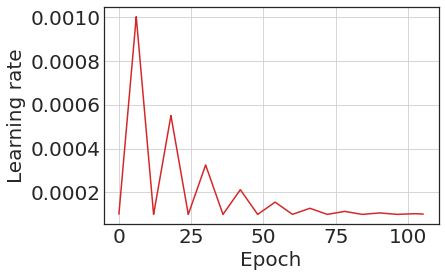

In [32]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")

Text(0.5, 45.5, 'Epochs')

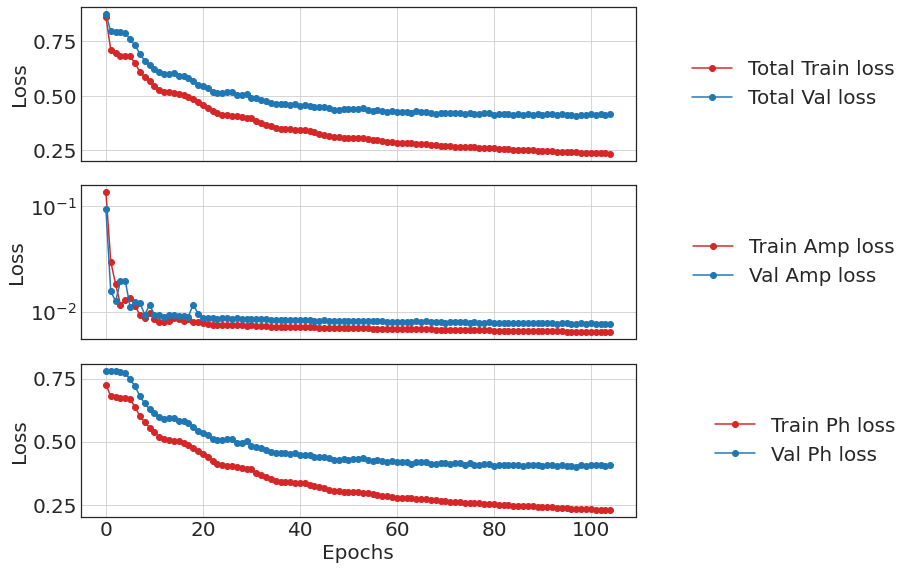

In [33]:
losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(3,sharex=True, figsize=(15, 8))
ax[0].plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax[0].plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax[0].set(ylabel='Loss')
ax[0].grid()
ax[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[1].plot(losses_arr[:,1], 'C3o-', label = "Train Amp loss")
ax[1].plot(val_losses_arr[:,1], 'C0o-', label = "Val Amp loss")
ax[1].set(ylabel='Loss')
ax[1].grid()
ax[1].set_yscale('log')
ax[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[2].plot(losses_arr[:,2], 'C3o-', label = "Train Ph loss")
ax[2].plot(val_losses_arr[:,2], 'C0o-', label = "Val Ph loss")
ax[2].set(ylabel='Loss')
ax[2].grid()
ax[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

plt.tight_layout()
plt.xlabel("Epochs")

In [34]:
model.eval() #imp when have dropout etc
amps_eval = []
phs_eval = []
for i, ft_images in enumerate(testloader):
    ft_images = ft_images[0].to(device)
    amp_eval, ph_eval = model(ft_images)
    for j in range(ft_images.shape[0]):
        amps_eval.append(amp_eval[j].detach().to("cpu").numpy())
        phs_eval.append(ph_eval[j].detach().to("cpu").numpy())

/home/skandel/miniconda3/envs/tf2/lib/python3.8/site-packages/torch/nn/functional.py:3118: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


In [35]:
amps_eval = np.array(amps_eval).squeeze()
phs_eval = np.array(phs_eval).squeeze()
print(amps_eval.shape, amps_eval.dtype)
print(phs_eval.shape, phs_eval.dtype)

(3600, 64, 64) float16
(3600, 64, 64) float16


<Figure size 432x288 with 0 Axes>

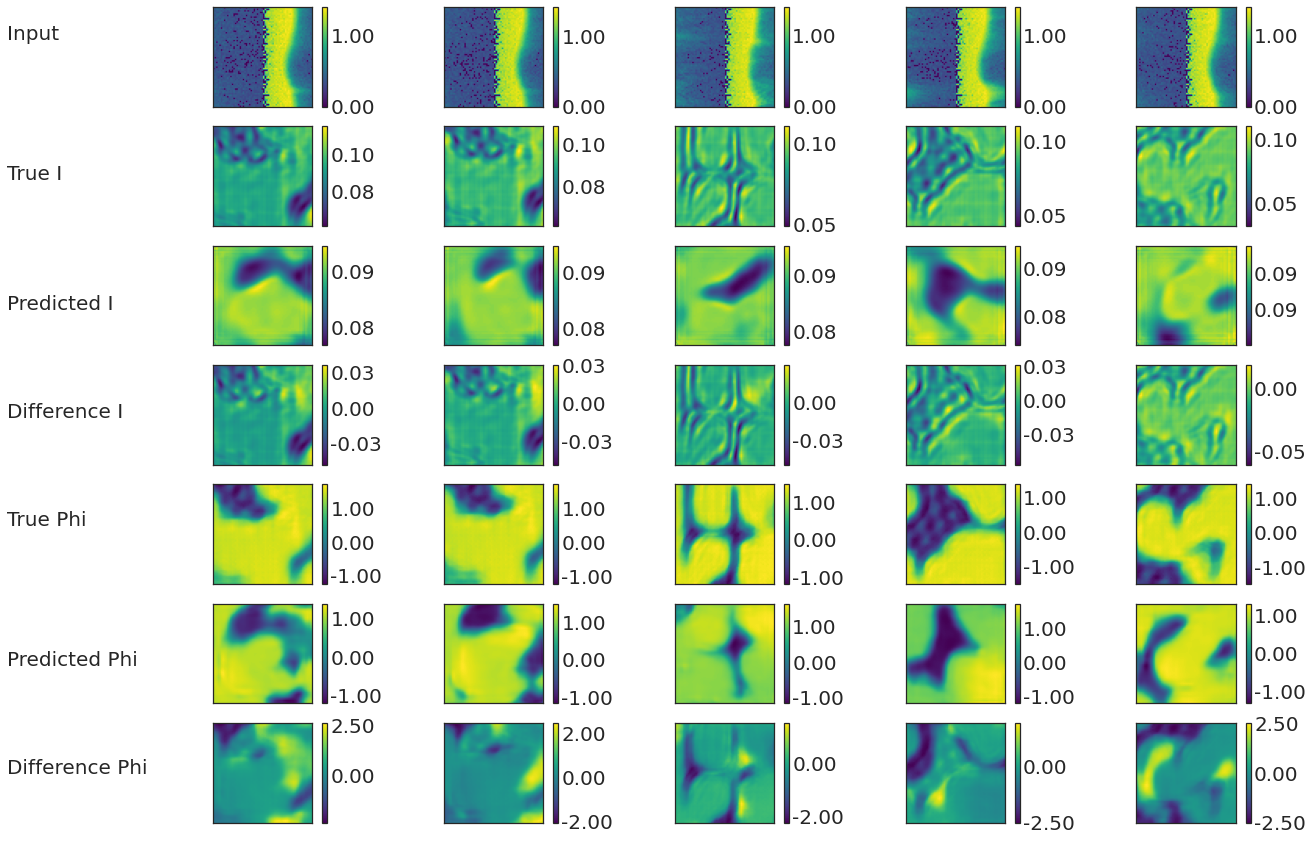

In [36]:
h,w = 64,64
ntest=amps_eval.shape[0]
plt.viridis()
n = 5
f,ax=plt.subplots(7,n,figsize=(20, 15))
plt.gcf().text(0.02, 0.85, "Input", fontsize=20)
plt.gcf().text(0.02, 0.72, "True I", fontsize=20)
plt.gcf().text(0.02, 0.6, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.5, "Difference I", fontsize=20)
plt.gcf().text(0.02, 0.4, "True Phi", fontsize=20)
plt.gcf().text(0.02, 0.27, "Predicted Phi", fontsize=20)
plt.gcf().text(0.02, 0.17, "Difference Phi", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

        # display FT

    im=ax[0,i].imshow(np.log10(X_test[j].reshape(h, w)+1))
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)
    
    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(amps_eval[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
        # display original phase
    im=ax[4,i].imshow(Y_phi_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[4,i], format='%.2f')
    ax[4,i].get_xaxis().set_visible(False)
    ax[4,i].get_yaxis().set_visible(False)
    
    # display predicted phase
    im=ax[5,i].imshow(phs_eval[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[5,i], format='%.2f')
    ax[5,i].get_xaxis().set_visible(False)
    ax[5,i].get_yaxis().set_visible(False)
    
    
    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w) - amps_eval[j].reshape(h, w))
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
    
    # Difference in phase
    im=ax[6,i].imshow(Y_phi_test[j].reshape(h, w) - phs_eval[j].reshape(h, w))
    plt.colorbar(im, ax=ax[6,i], format='%.2f')
    ax[6,i].get_xaxis().set_visible(False)
    ax[6,i].get_yaxis().set_visible(False)
    
plt.show()

In [37]:
point_size = 3
overlap = 4*point_size

In [38]:
tst_side = 60

composite_amp = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_amp)
data_reshaped = amps_eval.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_amp[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [39]:

composite_phase = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_phase)
data_reshaped = phs_eval.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_phase[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [40]:
stitched_phase = composite_phase[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp = composite_amp[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp_down = resize(stitched_amp, (60,60), preserve_range=True, anti_aliasing=True)
stitched_phase_down = resize(stitched_phase, (60,60), preserve_range=True, anti_aliasing=True)

In [41]:
true_amp = Y_I_test.reshape(NLTEST,NLTEST,64,64)
true_ph = Y_phi_test.reshape(NLTEST,NLTEST,64,64)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


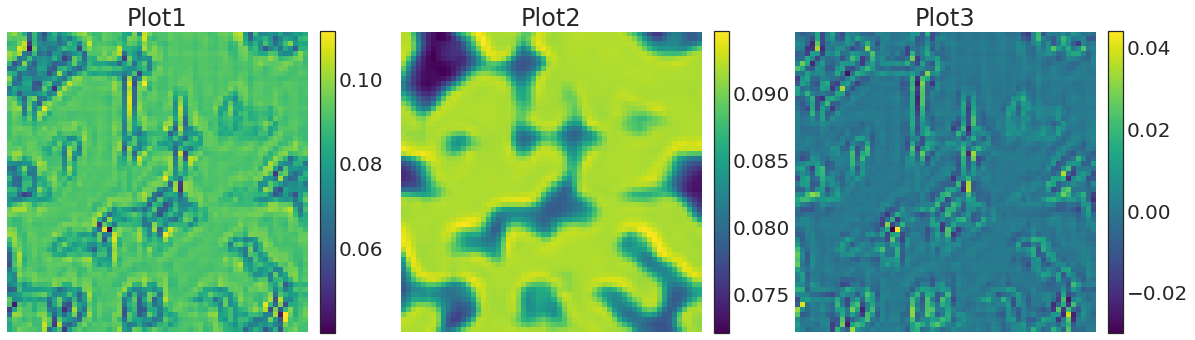

In [42]:
plot3([true_amp[:,:,32,32],stitched_amp_down,stitched_amp_down-true_amp[:,:,32,32]],[])

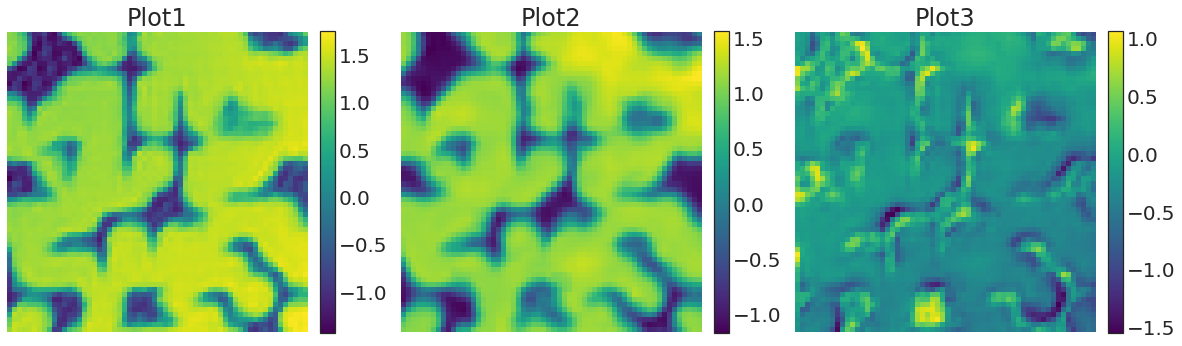

In [43]:
plot3([true_ph[:,:,32,32],stitched_phase_down,stitched_phase_down-true_ph[:,:,32,32]],[])

In [44]:
from sklearn.metrics import mean_squared_error as mse
from skimage.registration import phase_cross_correlation
print ("MSE in amplitude: ", mse(stitched_amp_down, true_amp[:,:,32,32]))
print ("MSE in phase: ", mse(stitched_phase_down, true_ph[:,:,32,32]))

MSE in amplitude:  5.407931037422724e-05
MSE in phase:  0.1489209150262204


In [45]:
true_img = true_amp * np.exp(1j * true_ph)
stitched_img = stitched_amp_down * np.exp(1j * stitched_phase_down)

In [46]:
_roll, _err, _phase = phase_cross_correlation(true_img[:,:,32, 32], stitched_img)
phase_cross_correlation(true_img[:,:,32,32], stitched_img * np.exp(1j * _phase))

(array([0., 0.]), 0.31171817731699825, -2.8884063103827764e-17)